# Benchmarking Compute Solutions for CNN Training
# A Case Study with Colab GPU (Tesla T4)

In [1]:
# Import libs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt

In [2]:
!pip install py-cpuinfo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cpuinfo (from versions: none)
ERROR: No matching distribution found for cpuinfo


In [3]:
import psutil
import cpuinfo

# Get CPU info
info = cpuinfo.get_cpu_info()

print('CPU Model: ', info['brand_raw'])
print('CPU Cores: ', psutil.cpu_count(logical=False)) # physical cores
print('CPU Threads: ', psutil.cpu_count(logical=True)) # logical cores i.e. with hyperthreading

CPU Model:  Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Cores:  1
CPU Threads:  2


In [4]:
# Get GPU model

if tf.test.is_gpu_available():
    #print("GPU")
    #print("GPU #0?")
    #print(tf.test.gpu_device_name())

    from tensorflow.python.client import device_lib
    #print("GPU #0 detailed info")
    print(device_lib.list_local_devices()[1])
else:
    print("No GPU detected")



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14328594432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1065587989603423774
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419



In [5]:
!wget https://storage.googleapis.com/data-lake-bucket-new/cat-vs-dogs-kaggle.zip

--2023-06-04 10:44:25--  https://storage.googleapis.com/data-lake-bucket-new/cat-vs-dogs-kaggle.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 172.253.118.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 572383158 (546M) [application/x-zip-compressed]
Saving to: ‘cat-vs-dogs-kaggle.zip’

cat-vs-dogs-kaggle. 100%[===================>] 545.87M  59.5MB/s    in 9.2s    

2023-06-04 10:44:34 (59.3 MB/s) - ‘cat-vs-dogs-kaggle.zip’ saved [572383158/572383158]



In [6]:
!ls -ltr

total 558976
drwxr-xr-x 1 root root      4096 Jun  1 22:51 sample_data
-rw-r--r-- 1 root root 572383158 Jun  4 03:53 cat-vs-dogs-kaggle.zip


In [7]:
!pwd

/content


In [8]:
!unzip cat-vs-dogs-kaggle.zip

Streaming output truncated to the last 5000 lines.
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5499.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.55.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.550.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5500.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5501.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5502.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5503.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5504.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5505.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5506.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5507.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5508.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5509.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.551.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5510.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog/dog.5511.jpg  
  inflating: cat-vs-dogs-kaggle/train/dog

In [9]:
# Define directories
train_dir = '/content/cat-vs-dogs-kaggle/train/'
test_dir = '/content/cat-vs-dogs-kaggle/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the source directory for training images
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_cross entropy loss, we need binary labels
    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [11]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
start_time = time.time()
print(f'\nMODEL TRAINING:')
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1
)
print(f"DNN training time: {time.time() - start_time} seconds")


MODEL TRAINING:
Epoch 1/15
1200/1200 [==============================] - 93s 70ms/step - loss: 0.5776 - accuracy: 0.7012 - val_loss: 0.4493 - val_accuracy: 0.7920
Epoch 2/15
1200/1200 [==============================] - 81s 67ms/step - loss: 0.4576 - accuracy: 0.7863 - val_loss: 0.4050 - val_accuracy: 0.8030
Epoch 3/15
1200/1200 [==============================] - 80s 67ms/step - loss: 0.4055 - accuracy: 0.8215 - val_loss: 0.4058 - val_accuracy: 0.8120
Epoch 4/15
1200/1200 [==============================] - 79s 66ms/step - loss: 0.3732 - accuracy: 0.8398 - val_loss: 0.3447 - val_accuracy: 0.8530
Epoch 5/15
1200/1200 [==============================] - 85s 71ms/step - loss: 0.3391 - accuracy: 0.8591 - val_loss: 0.4415 - val_accuracy: 0.7920
Epoch 6/15
1200/1200 [==============================] - 82s 68ms/step - loss: 0.3203 - accuracy: 0.8699 - val_loss: 0.3986 - val_accuracy: 0.8500
Epoch 7/15
1200/1200 [==============================] - 81s 68ms/step - loss: 0.3104 - accuracy: 0.8740 - v

In [13]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 [==============================] - 3s 61ms/step - loss: 0.7608 - accuracy: 0.7680
Validation Loss: 0.7607960104942322
Validation Accuracy: 0.7680000066757202


In [14]:
# Save Model
model.save('/Users/tharindu/Downloads/cat-vs-dogs-kaggle/cat-dog-model.keras', save_format='tf')

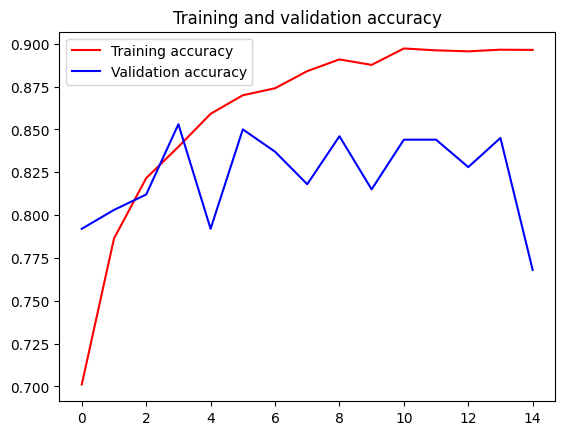

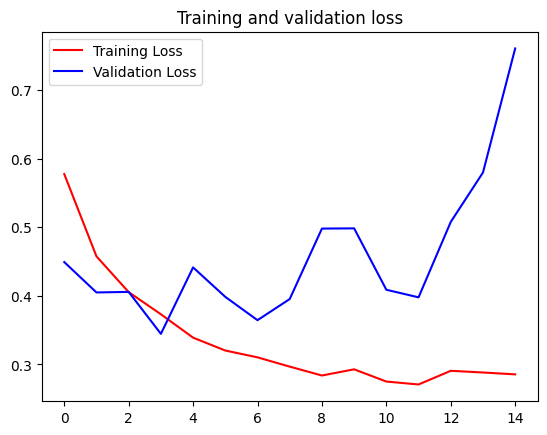

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
